In [ ]:
# Make sure to upload dataset as archive.zip on the runtime files

In [1]:
import os
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import cv2
from tqdm import tqdm
import random
import glob

In [2]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")

# Setup GPU for TensorFlow
def setup_gpu():
    """Configure TensorFlow to use GPU if available"""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Set memory growth to avoid allocating all GPU memory
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set visible devices to only include the first GPU
            tf.config.set_visible_devices(gpus[0], 'GPU')

            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Using {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        except RuntimeError as e:
            print(f"GPU setup error: {e}")
    else:
        print("No GPU available. Using CPU.")


Running in Google Colab


In [12]:
# Extract the dataset
def extract_dataset():
    """Extract the LFW dataset from the uploaded files"""
    print("Extracting dataset...")

    # Handle Colab uploads
    if IN_COLAB:
        from google.colab import files

        # Check if archive.zip exists, if not prompt for upload
        if not os.path.exists('archive.zip'):
            print("Please upload the archive.zip file")
            uploaded = files.upload()

            if 'archive.zip' not in uploaded:
                print("archive.zip was not uploaded!")
                return False

    # Extract the main zip file if it exists
    if os.path.exists('archive.zip'):
        with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Extracted archive.zip")
    else:
        print("archive.zip not found!")
        return False

    # Extract the tar.gz file if it exists
    if os.path.exists('lfw-funneled.tgz'):
        with tarfile.open('lfw-funneled.tgz', 'r:gz') as tar_ref:
            tar_ref.extractall('.')
        print("Extracted lfw-funneled.tgz")
        return True
    else:
        print("lfw-funneled.tgz not found!")
        return False

In [18]:
# Install required packages if in Colab
def install_requirements():
    """Install required packages if running in Colab"""
    if IN_COLAB:
        print("Installing required packages...")
        !pip install -q opencv-python matplotlib tqdm scikit-learn

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define constants
IMG_SIZE = 160  # FaceNet uses 160x160 images
BATCH_SIZE = 32
EPOCHS = 20
EMBEDDING_SIZE = 128  # Size of the face embedding vector
ALPHA = 0.2  # Alpha for LeakyReLU
TRIPLET_MARGIN = 0.2  # Margin for triplet loss


# Load and preprocess the LFW dataset
def load_lfw_dataset(lfw_dir='lfw_funneled', min_images_per_person=10):
    """
    Load the LFW dataset into memory
    Only keep people who have at least min_images_per_person images
    """
    print("Loading LFW dataset...")

    people_dict = {}

    # Iterate through the directory
    for person_dir in os.listdir(lfw_dir):
        person_path = os.path.join(lfw_dir, person_dir)
        if os.path.isdir(person_path):
            image_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
            if len(image_files) >= min_images_per_person:
                people_dict[person_dir] = [os.path.join(person_path, img) for img in image_files]

    print(f"Found {len(people_dict)} people with at least {min_images_per_person} images each")

    # Load and preprocess images
    images = []
    labels = []
    names = list(people_dict.keys())

    for i, name in enumerate(tqdm(names)):
        for img_path in people_dict[name]:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0  # Normalize to [0,1]

            images.append(img)
            labels.append(i)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"Dataset loaded: {images.shape[0]} images, {len(names)} people")

    return images, labels, names


In [14]:
# Define the FaceNet architecture from scratch
def build_facenet_model():
    """Build a FaceNet model based on the original paper architecture"""

    def conv_block(x, filters, kernel_size, strides=1, padding='same', use_relu=True):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        if use_relu:
            x = layers.LeakyReLU(alpha=ALPHA)(x)
        return x

    def inception_block(x, filters):
        # 1x1 convolution
        branch_1 = conv_block(x, filters[0], 1)

        # 1x1 -> 3x3 convolution
        branch_2 = conv_block(x, filters[1][0], 1)
        branch_2 = conv_block(branch_2, filters[1][1], 3)

        # 1x1 -> 5x5 convolution
        branch_3 = conv_block(x, filters[2][0], 1)
        branch_3 = conv_block(branch_3, filters[2][1], 5)

        # 3x3 pooling -> 1x1 convolution
        branch_4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
        branch_4 = conv_block(branch_4, filters[3], 1)

        # Concatenate all branches
        return layers.Concatenate()([branch_1, branch_2, branch_3, branch_4])

    # Input layer
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Initial convolution layers
    x = conv_block(inputs, 32, 3, strides=2, padding='valid')  # 160x160 -> 79x79
    x = conv_block(x, 32, 3, padding='valid')  # 79x79 -> 77x77
    x = conv_block(x, 64, 3)
    x = layers.MaxPooling2D(3, strides=2)(x)  # 77x77 -> 38x38

    x = conv_block(x, 80, 1, padding='valid')
    x = conv_block(x, 192, 3, padding='valid')  # 38x38 -> 36x36
    x = layers.MaxPooling2D(3, strides=2)(x)  # 36x36 -> 17x17

    # Inception modules
    x = inception_block(x, [64, [48, 64], [64, 96], 32])
    x = inception_block(x, [64, [48, 64], [64, 96], 64])
    x = inception_block(x, [64, [48, 64], [64, 96], 64])

    # Intermediate pooling
    x = layers.MaxPooling2D(3, strides=2)(x)  # 17x17 -> 8x8

    # More inception modules
    x = inception_block(x, [192, [96, 208], [16, 48], 64])
    x = inception_block(x, [160, [112, 224], [24, 64], 64])
    x = inception_block(x, [128, [128, 256], [24, 64], 64])
    x = inception_block(x, [112, [144, 288], [32, 64], 64])
    x = inception_block(x, [256, [160, 320], [32, 128], 128])

    # Final pooling
    x = layers.MaxPooling2D(3, strides=2)(x)  # 8x8 -> 3x3

    # Final inception modules
    x = inception_block(x, [256, [160, 320], [32, 128], 128])
    x = inception_block(x, [384, [192, 384], [48, 128], 128])

    # Global pooling and embedding layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(EMBEDDING_SIZE)(x)

    # L2 normalization for embedding
    embeddings = layers.Lambda(lambda x: K.l2_normalize(x, axis=1))(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=embeddings)

    return model


In [15]:
# Define triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Implementation of triplet loss function

    Args:
        y_true: not used, but needed for Keras loss function API
        y_pred: embeddings tensor of shape (batch_size, embedding_size)

    Note: Assumes that inputs are provided as triplets (anchor, positive, negative)
    """
    # Get the batch size
    batch_size = tf.shape(y_pred)[0] // 3

    # Split the batch into anchors, positives, and negatives
    anchors = y_pred[0:batch_size]
    positives = y_pred[batch_size:2*batch_size]
    negatives = y_pred[2*batch_size:3*batch_size]

    # Calculate distances
    pos_dist = tf.reduce_sum(tf.square(anchors - positives), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchors - negatives), axis=1)

    # Calculate triplet loss
    basic_loss = pos_dist - neg_dist + TRIPLET_MARGIN
    loss = tf.maximum(basic_loss, 0.0)

    return tf.reduce_mean(loss)

# Create triplets for training
def generate_triplets(images, labels, num_triplets=1000):
    """Generate triplets (anchor, positive, negative) for training"""
    triplets = []

    # Get unique labels and their indices
    unique_labels = np.unique(labels)
    label_dict = {label: np.where(labels == label)[0] for label in unique_labels}

    # Generate triplets
    for _ in range(num_triplets):
        # Pick a random anchor class
        anchor_class = np.random.choice(unique_labels)

        # Pick a random sample from the anchor class
        anchor_idx = np.random.choice(label_dict[anchor_class])

        # Pick a random positive sample from the same class
        pos_indices = label_dict[anchor_class]
        pos_indices = pos_indices[pos_indices != anchor_idx]  # Exclude the anchor

        if len(pos_indices) == 0:  # Skip if no other samples in this class
            continue

        pos_idx = np.random.choice(pos_indices)

        # Pick a random negative sample from a different class
        neg_classes = [c for c in unique_labels if c != anchor_class]
        neg_class = np.random.choice(neg_classes)
        neg_idx = np.random.choice(label_dict[neg_class])

        triplets.append((anchor_idx, pos_idx, neg_idx))

    return np.array(triplets)

# Triplet generator
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.unique_labels = np.unique(labels)
        self.label_dict = {label: np.where(labels == label)[0] for label in self.unique_labels}

        # Only keep classes with at least 2 samples
        self.valid_classes = [l for l in self.unique_labels if len(self.label_dict[l]) >= 2]

    def __len__(self):
        return int(np.ceil(len(self.valid_classes) / self.batch_size))

    def __getitem__(self, idx):
        batch_triplets = self._generate_triplets(self.batch_size)

        # Extract images for the triplets
        anchors = np.array([self.images[i] for i, _, _ in batch_triplets])
        positives = np.array([self.images[j] for _, j, _ in batch_triplets])
        negatives = np.array([self.images[k] for _, _, k in batch_triplets])

        # Stack the images
        X = np.vstack([anchors, positives, negatives])

        # Dummy target for triplet loss
        y = np.zeros((len(batch_triplets) * 3, EMBEDDING_SIZE))

        return X, y

    def on_epoch_end(self):
        pass

    def _generate_triplets(self, num_triplets):
        triplets = []

        for _ in range(num_triplets):
            # Pick a random anchor class that has at least 2 samples
            anchor_class = np.random.choice(self.valid_classes)

            # Pick a random anchor and positive sample
            class_indices = self.label_dict[anchor_class]
            anchor_idx, pos_idx = np.random.choice(class_indices, 2, replace=False)

            # Pick a random negative class and sample
            neg_classes = [c for c in self.unique_labels if c != anchor_class]
            neg_class = np.random.choice(neg_classes)
            neg_idx = np.random.choice(self.label_dict[neg_class])

            triplets.append((anchor_idx, pos_idx, neg_idx))

        return triplets

# Visualization functions
def visualize_triplets(images, triplets, num_examples=3):
    """Visualize some example triplets"""
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4*num_examples))

    for i in range(num_examples):
        if i < len(triplets):
            anchor_idx, pos_idx, neg_idx = triplets[i]

            axes[i, 0].imshow(images[anchor_idx])
            axes[i, 0].set_title('Anchor')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(images[pos_idx])
            axes[i, 1].set_title('Positive')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(images[neg_idx])
            axes[i, 2].set_title('Negative')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
def plot_embeddings_2d(embeddings, labels, names, n_classes=10):
    """Plot the embeddings reduced to 2D using t-SNE"""
    from sklearn.manifold import TSNE

    # Select a subset of the embeddings for clarity
    unique_labels = np.unique(labels)
    selected_classes = unique_labels[:n_classes]

    mask = np.isin(labels, selected_classes)

    selected_embeddings = embeddings[mask]
    selected_labels = labels[mask]

    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plot
    plt.figure(figsize=(12, 10))

    for i, label in enumerate(selected_classes):
        indices = np.where(selected_labels == label)[0]
        plt.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            label=names[label],
            alpha=0.7
        )

    plt.legend()
    plt.title('2D visualization of face embeddings using t-SNE')
    plt.tight_layout()
    plt.show()

# Face verification function
def verify_faces(model, img1_path, img2_path, threshold=0.7):
    """Verify if two face images are of the same person"""
    # Load and preprocess images
    img1 = cv2.imread(img1_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
    img1 = img1.astype('float32') / 255.0

    img2 = cv2.imread(img2_path)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))
    img2 = img2.astype('float32') / 255.0

    # Get embeddings
    embedding1 = model.predict(np.expand_dims(img1, axis=0))[0]
    embedding2 = model.predict(np.expand_dims(img2, axis=0))[0]

    # Calculate cosine similarity
    similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    return similarity, similarity >= threshold

# Evaluate model on verification task
def evaluate_verification(model, test_images, test_labels, num_pairs=1000):
    """Evaluate the model on a face verification task"""

    # Generate pairs
    pairs = []
    labels_pair = []

    unique_labels = np.unique(test_labels)
    label_dict = {label: np.where(test_labels == label)[0] for label in unique_labels}

    # Generate positive pairs (same person)
    positive_count = 0
    for label in unique_labels:
        indices = label_dict[label]
        if len(indices) >= 2:
            pairs_needed = min(num_pairs // 2 // len(unique_labels) + 1, len(indices) * (len(indices) - 1) // 2)
            pairs_count = 0

            while pairs_count < pairs_needed and positive_count < num_pairs // 2:
                idx1, idx2 = np.random.choice(indices, 2, replace=False)
                pairs.append((idx1, idx2))
                labels_pair.append(1)  # Same person
                pairs_count += 1
                positive_count += 1

    # Generate negative pairs (different people)
    negative_count = 0
    while negative_count < num_pairs // 2:
        label1, label2 = np.random.choice(unique_labels, 2, replace=False)
        idx1 = np.random.choice(label_dict[label1])
        idx2 = np.random.choice(label_dict[label2])

        pairs.append((idx1, idx2))
        labels_pair.append(0)  # Different people
        negative_count += 1

    # Compute embeddings
    embeddings = model.predict(test_images)

    # Calculate similarities and predictions
    similarities = []
    for idx1, idx2 in pairs:
        embedding1 = embeddings[idx1]
        embedding2 = embeddings[idx2]

        # Cosine similarity
        similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
        similarities.append(similarity)

    # Find the best threshold
    thresholds = np.arange(0.3, 1.0, 0.05)
    accuracies = []

    for threshold in thresholds:
        predictions = [1 if s >= threshold else 0 for s in similarities]
        accuracy = accuracy_score(labels_pair, predictions)
        accuracies.append(accuracy)

    best_threshold_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_threshold_idx]
    best_accuracy = accuracies[best_threshold_idx]

    # Final evaluation with best threshold
    predictions = [1 if s >= best_threshold else 0 for s in similarities]
    conf_matrix = confusion_matrix(labels_pair, predictions)

    return {
        'accuracy': best_accuracy,
        'threshold': best_threshold,
        'confusion_matrix': conf_matrix
    }


Installing required packages...
No GPU available. Using CPU.
No GPU found. Using CPU instead.
Extracting dataset...
Extracted archive.zip
Extracted lfw-funneled.tgz
Loading LFW dataset...
Found 158 people with at least 10 images each


100%|██████████| 158/158 [00:04<00:00, 38.84it/s]


Dataset loaded: 4324 images, 158 people
Training set: 3459 images
Test set: 865 images
Building FaceNet model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Using custom FaceNet model from scratch


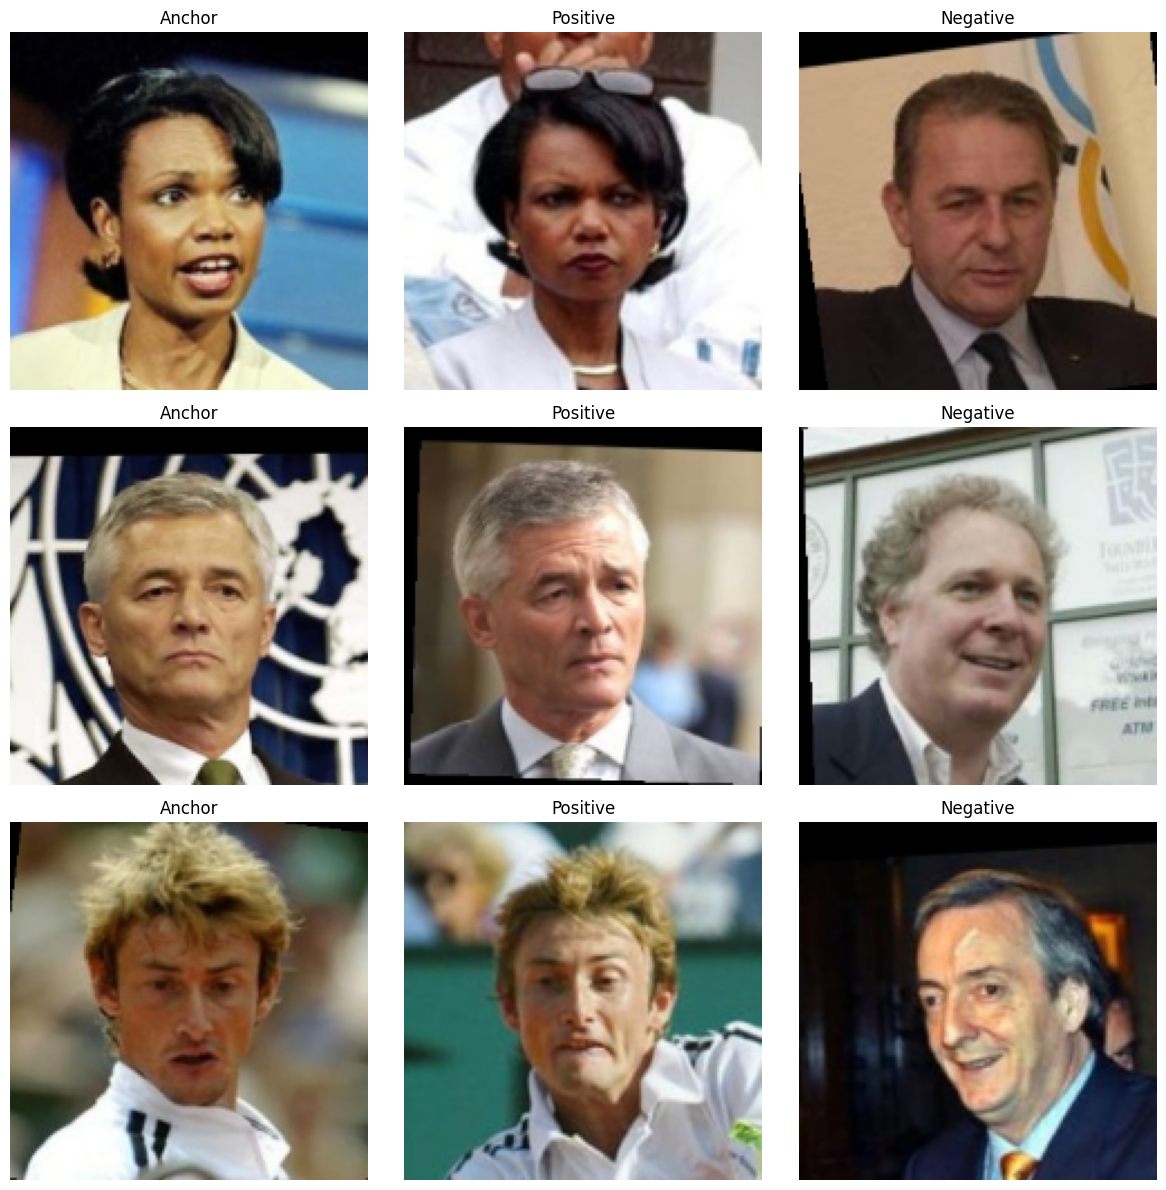


Training FaceNet model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3288

16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - loss: 0.3329 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3278

16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.3266 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2118

16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.2121 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1678

16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.1682 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1912

16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.1899 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.1576 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1578

16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - loss: 0.1584 - learning_rate: 0.0010
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.1938 - learning_rate: 0.0010
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.1801 - learning_rate: 0.0010
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.1932 - learning_rate: 0.0010
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.1821 - learning_rate: 5.0000e-04
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.1784 - learning_rate: 5.0000e-04


Model saved to models/facenet_final.h5


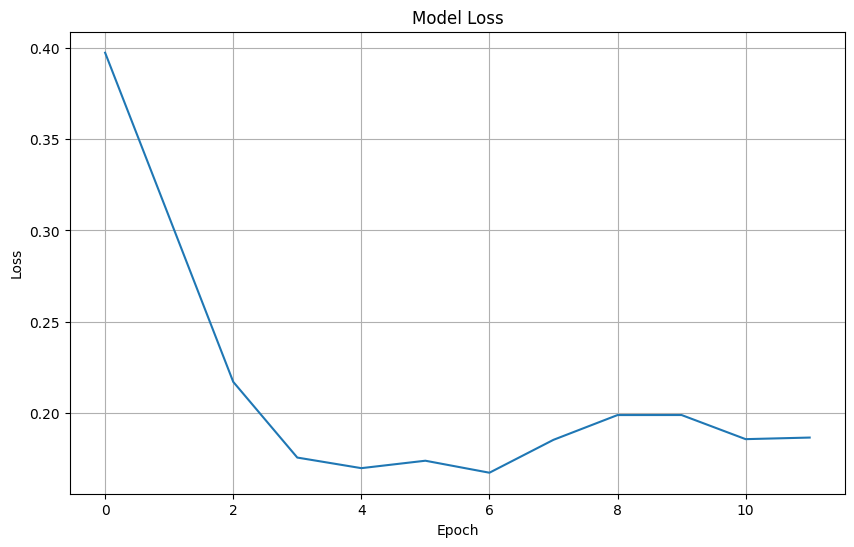


Generating embeddings for visualization...
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


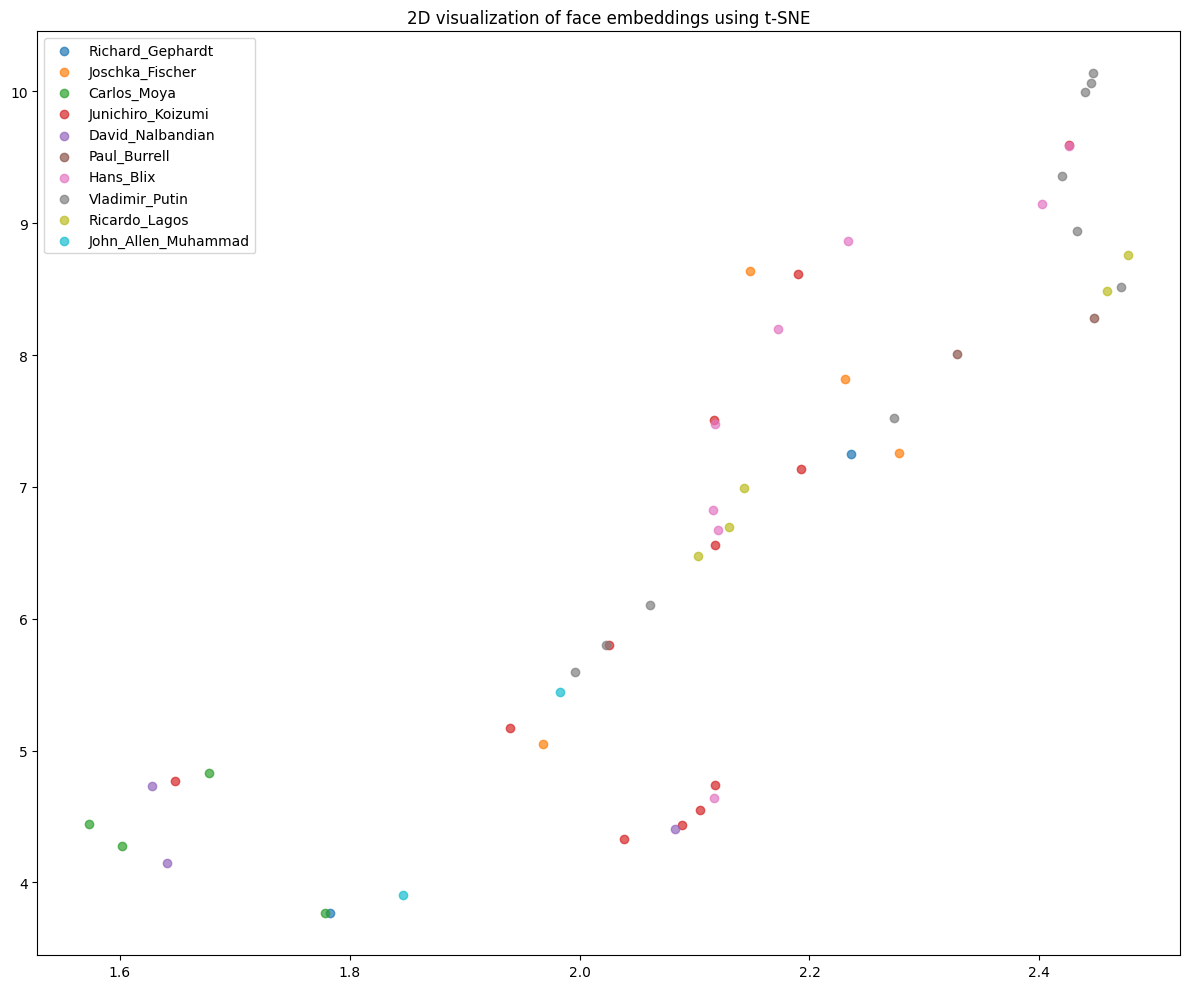


Evaluating face verification performance...
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 955ms/step
Verification accuracy: 0.4824
Best threshold: 0.3000
Confusion Matrix:
[[  0 500]
 [  0 466]]

Example of face verification:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Same person verification - Similarity: 0.9937, Same: True
Person: Joe_Lieberman


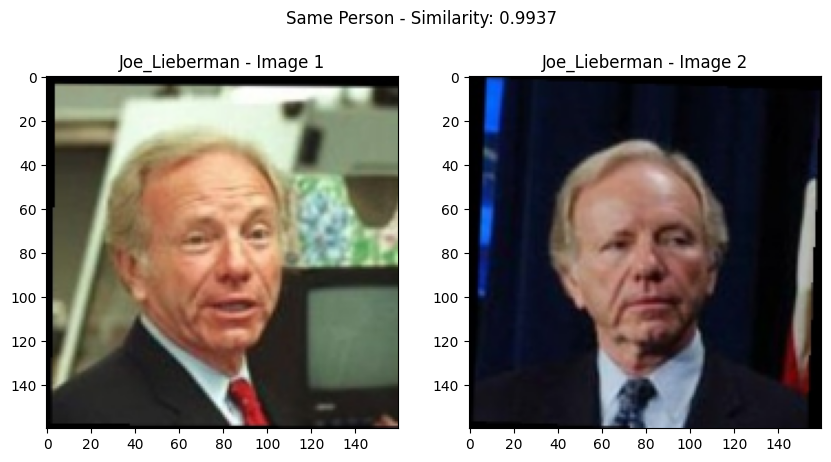

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Different person verification - Similarity: 0.9973, Same: True
Persons: Adrien_Brody and Paul_Bremer


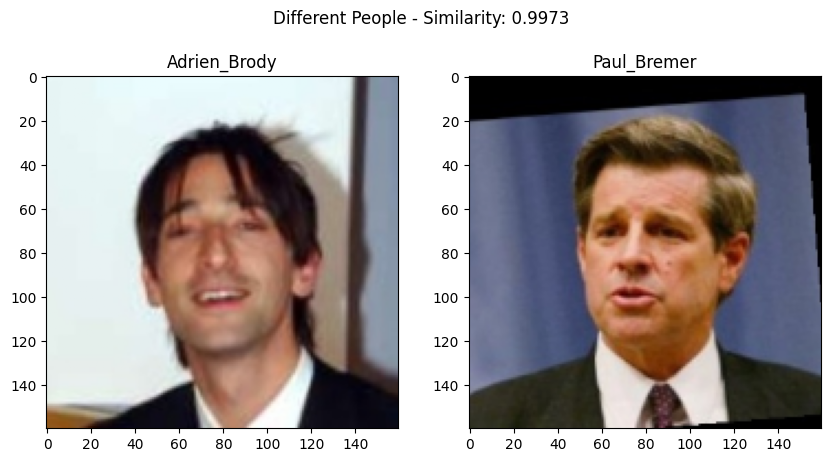


Function test_with_own_images() is available to test with your own images.


In [19]:
# Main execution function
def main():
    # Setup for Colab
    if IN_COLAB:
        install_requirements()

    # Configure GPU
    setup_gpu()

    # Check TensorFlow is using GPU
    if tf.test.gpu_device_name():
        print('GPU found')
        print(f"Using GPU: {tf.test.gpu_device_name()}")
        # Print GPU details for T4 verification
        !nvidia-smi
    else:
        print("No GPU found. Using CPU instead.")

    # Extract the dataset
    if not extract_dataset():
        print("Error extracting dataset. Please make sure archive.zip exists and contains lfw_funneled.tgz")
        return

    # Load the LFW dataset
    images, labels, names = load_lfw_dataset(min_images_per_person=10)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"Training set: {X_train.shape[0]} images")
    print(f"Test set: {X_test.shape[0]} images")

    # Create the model
    print("Building FaceNet model...")
    # Choose which model to use

    model = build_facenet_model()  # Use from-scratch model
    print("Using custom FaceNet model from scratch")

    # Create triplet generator
    triplet_gen = TripletGenerator(X_train, y_train, batch_size=BATCH_SIZE//3)

    # Generate some triplets for visualization
    vis_triplets = triplet_gen._generate_triplets(5)
    visualize_triplets(X_train, vis_triplets)

    # Set up mixed precision training for better performance on T4 GPU
    if tf.test.gpu_device_name():
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print('Mixed precision enabled')

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=triplet_loss
    )

    # Create output directory for saving model
    if not os.path.exists('models'):
        os.makedirs('models')

    # Callbacks with TensorBoard for Colab
    callbacks = [
        ModelCheckpoint('models/facenet_model.h5', save_best_only=True, monitor='loss'),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6),
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    ]

    if IN_COLAB:
        from tensorflow.keras.callbacks import TensorBoard
        import datetime
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        callbacks.append(tensorboard_callback)

    # Train the model
    print("\nTraining FaceNet model...")
    history = model.fit(
        triplet_gen,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Save model for later use
    model.save('models/facenet_final.h5')
    print("Model saved to models/facenet_final.h5")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

    # Generate embeddings for visualization
    print("\nGenerating embeddings for visualization...")
    test_embeddings = model.predict(X_test)

    # Visualize embeddings
    plot_embeddings_2d(test_embeddings, y_test, names)

    # Evaluate on verification task
    print("\nEvaluating face verification performance...")
    verification_results = evaluate_verification(model, X_test, y_test)

    print(f"Verification accuracy: {verification_results['accuracy']:.4f}")
    print(f"Best threshold: {verification_results['threshold']:.4f}")
    print("Confusion Matrix:")
    print(verification_results['confusion_matrix'])

    # Example of face verification
    print("\nExample of face verification:")
    # Get two images of the same person
    same_person_label = random.choice(np.unique(y_test))
    same_person_indices = np.where(y_test == same_person_label)[0]
    if len(same_person_indices) >= 2:
        idx1, idx2 = np.random.choice(same_person_indices, 2, replace=False)

        # Save images temporarily
        cv2.imwrite("temp_same1.jpg", X_test[idx1] * 255)
        cv2.imwrite("temp_same2.jpg", X_test[idx2] * 255)

        similarity, is_same = verify_faces(model, "temp_same1.jpg", "temp_same2.jpg",
                                         threshold=verification_results['threshold'])

        print(f"Same person verification - Similarity: {similarity:.4f}, Same: {is_same}")
        print(f"Person: {names[same_person_label]}")

        # Display images in Colab
        if IN_COLAB:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(X_test[idx1])
            plt.title(f"{names[same_person_label]} - Image 1")
            plt.subplot(1, 2, 2)
            plt.imshow(X_test[idx2])
            plt.title(f"{names[same_person_label]} - Image 2")
            plt.suptitle(f"Same Person - Similarity: {similarity:.4f}")
            plt.show()

    # Get two images of different people
    diff_labels = np.random.choice(np.unique(y_test), 2, replace=False)
    idx1 = np.random.choice(np.where(y_test == diff_labels[0])[0])
    idx2 = np.random.choice(np.where(y_test == diff_labels[1])[0])

    # Save images temporarily
    cv2.imwrite("temp_diff1.jpg", X_test[idx1] * 255)
    cv2.imwrite("temp_diff2.jpg", X_test[idx2] * 255)

    similarity, is_same = verify_faces(model, "temp_diff1.jpg", "temp_diff2.jpg",
                                     threshold=verification_results['threshold'])

    print(f"Different person verification - Similarity: {similarity:.4f}, Same: {is_same}")
    print(f"Persons: {names[diff_labels[0]]} and {names[diff_labels[1]]}")

    # Display images in Colab
    if IN_COLAB:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X_test[idx1])
        plt.title(f"{names[diff_labels[0]]}")
        plt.subplot(1, 2, 2)
        plt.imshow(X_test[idx2])
        plt.title(f"{names[diff_labels[1]]}")
        plt.suptitle(f"Different People - Similarity: {similarity:.4f}")
        plt.show()

    # Clean up temporary files
    for f in ["temp_same1.jpg", "temp_same2.jpg", "temp_diff1.jpg", "temp_diff2.jpg"]:
        if os.path.exists(f):
            os.remove(f)

    # Additional Colab-specific display
    if IN_COLAB:
        from google.colab import files

        # Create an example inference function for Colab users to test with their own images
        def test_with_own_images():
            print("Upload two face images to test verification:")
            uploaded = files.upload()

            if len(uploaded) >= 2:
                img_paths = list(uploaded.keys())
                img1_path = img_paths[0]
                img2_path = img_paths[1]

                print(f"Comparing {img1_path} and {img2_path}")
                similarity, is_same = verify_faces(model, img1_path, img2_path,
                                                 threshold=verification_results['threshold'])

                print(f"Similarity: {similarity:.4f}")
                print(f"Same person: {is_same}")

                # Display the images
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(plt.imread(img1_path))
                plt.title("Image 1")
                plt.subplot(1, 2, 2)
                plt.imshow(plt.imread(img2_path))
                plt.title("Image 2")
                plt.suptitle(f"Similarity: {similarity:.4f}, Same Person: {is_same}")
                plt.show()

        print("\nFunction test_with_own_images() is available to test with your own images.")

if __name__ == "__main__":
    main()